In [1]:
import pandas as pd
import requests
from typing import List
import numpy as np
import pandas_ta
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [2]:
def get_sp500_tickers() -> List[str]:
    """
    Scrapes the current list of S&P 500 constituent stock tickers from Wikipedia.
    
    Uses requests with a User-Agent to prevent HTTP 403 Forbidden errors, 
    then uses pandas.read_html() to parse the HTML table.

    Returns:
        A list of strings containing the S&P 500 company tickers.
        Returns an empty list [] if fetching or parsing fails.
    """
    WIKI_URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    
    # Define a standard User-Agent header to avoid 403 Forbidden errors
    HEADERS = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        print(f"Attempting to fetch HTML content from: {WIKI_URL}")
        
        # 1. Fetch the HTML content using requests with a User-Agent
        response = requests.get(WIKI_URL, headers=HEADERS, timeout=10)
        response.raise_for_status() # Raise an exception for HTTP errors (like 403)
        tables = pd.read_html(response.text)
        sp500_table = tables[1]
        
        if 'Symbol' in sp500_table.columns:
            # 4. Extract and clean the tickers
            tickers = sp500_table['Symbol'].tolist()
            
            # Clean up potential odd entries (like leading/trailing whitespace or footnotes)
            tickers = [ticker.strip().replace('.', '-') for ticker in tickers if isinstance(ticker, str)]
            
            print(f"Successfully retrieved {len(tickers)} tickers.")
            return tickers
        else:
            print("Error: Could not find the 'Symbol' column in the expected table structure.")
            return []
            
    except requests.exceptions.HTTPError as e:
        # Catch 4XX errors specifically
        print(f"Error: HTTP Status {e.response.status_code}. The server rejected the request. Try running again.")
        return []
    except Exception as e:
        print(f"An error occurred while scraping the Wikipedia page: {e}")
        print("This may be due to a network error, a change in the Wikipedia page structure, or missing dependencies.")
        return []


sp500_list = get_sp500_tickers()
    

Attempting to fetch HTML content from: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
Successfully retrieved 503 tickers.


C:\Users\kudam\AppData\Local\Temp\ipykernel_25944\2972335050.py:25: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [3]:
sp500_list[:5]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']

In [4]:
import yfinance as yf
# Download historical data for all tickers from 2016-01-01
data = yf.download(tickers=sp500_list, start='2015-01-04', end='2025-08-31', auto_adjust=False, group_by='ticker', threads=True)

if not data.empty:
    print('Data fetched successfully for S&P 500 tickers!')
    df = data
else:
    print('Failed to fetch data for S&P 500 tickers.')
    df = None

df.columns = df.columns.swaplevel(0, 1)
df = df.sort_index(axis=1, level=0)
df = df.stack()

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['Q', 'SOLS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-04 -> 2025-08-31) (Yahoo error = "Data doesn\'t exist for startDate = 1420347600, endDate = 1756612800")')


Data fetched successfully for S&P 500 tickers!


C:\Users\kudam\AppData\Local\Temp\ipykernel_25944\2145885422.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


In [5]:
df

Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2015-01-05 A        36.425388   39.799999   40.459999   39.700001   40.320000   
           AAPL     23.554741   26.562500   27.162500   26.352501   27.072500   
           ABBV     41.299301   64.650002   66.099998   63.880001   65.500000   
           ABT      36.426781   44.910000   45.400002   44.630001   44.799999   
           ACGL     18.428413   19.379999   19.500000   19.333332   19.393333   
...                       ...         ...         ...         ...         ...   
2025-08-29 XYZ      79.639999   79.639999   82.250000   79.139999   80.800003   
           YUM     146.260010  146.970001  147.350006  145.399994  145.410004   
           ZBH     105.840904  106.099998  106.160004  105.050003  105.190002   
           ZBRA    317.089996  317.089996  321.660004  315.829987  321.660004   
           ZTS     155.857315  156.399994  156.490005  154.070007  154.639999   

Price                   Volume  
Date       Ticker               
2015-01-05 A         2041800.0  
           AAPL    257142000.0  
           ABBV      8007400.0  
           ABT       5735900.0  
           ACGL      1095900.0  
...                        ...  
2025-08-29 XYZ       6205700.0  
           YUM       1473400.0  
           ZBH        680100.0  
           ZBRA       440900.0  
           ZTS       1534600.0  

[1301889 rows x 6 columns]

In [6]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['High'] - np.log(df['Low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['Adj Close']) - np.log(df['Open']) ** 2))
df['rsi'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: pandas_ta.rsi(x, length=20))
df['bb_low'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='Ticker')['Adj Close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Date'>

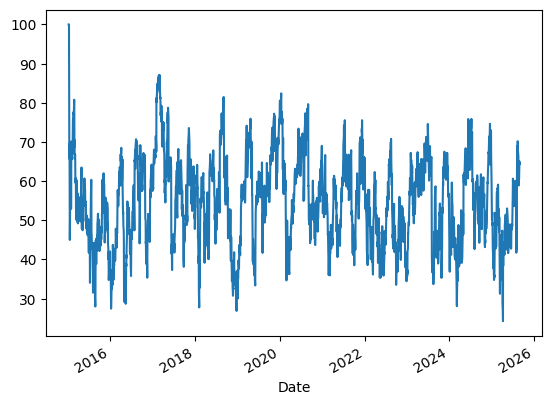

In [7]:
# All 'Close' prices for ticker 'AAPL' across all dates
df.xs('AAPL', level='Ticker')['rsi'].plot()

In [8]:
df.xs('A', level='Ticker')

Price,Adj Close,Close,High,Low,Open,Volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high
Date,,,,,,,,,,,
2015-01-05,36.425388,39.799999,40.459999,39.700001,40.320000,2041800.0,5.536737,NaN,NaN,NaN,NaN
2015-01-06,35.857956,39.180000,40.020000,39.020000,39.810001,2080600.0,5.500655,0.000000,NaN,NaN,NaN
2015-01-07,36.333866,39.700001,39.810001,39.290001,39.520000,3359700.0,5.469849,4.227635,NaN,NaN,NaN
2015-01-08,37.422970,40.889999,40.980000,40.180000,40.240002,2116300.0,5.528581,13.079602,NaN,NaN,NaN
2015-01-09,37.148399,40.590000,41.000000,40.290001,41.000000,1644900.0,5.584968,12.766468,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25,118.911224,119.150002,121.690002,118.480003,121.500000,1482500.0,9.351057,52.574595,4.724850,4.769673,4.814495
2025-08-26,118.062927,118.300003,119.629997,118.110001,119.230003,1898200.0,9.273650,51.277935,4.725227,4.769031,4.812835
2025-08-27,118.452141,118.690002,119.199997,117.510002,118.500000,1698600.0,9.247735,51.851456,4.725211,4.769299,4.813388


In [9]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Adj Close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [10]:
df['atr'] = df.groupby(level='Ticker', group_keys=False).apply(compute_atr)

In [11]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [12]:
df['macd'] = df.groupby(level='Ticker', group_keys=False)['Adj Close'].apply(compute_macd)

In [13]:
df['dollar_volume'] = (df['Volume'] * df['Adj Close'])/1e6

In [14]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'Volume', 'Open', 'High', 'Low', 'Close']]
data = pd.concat([df.unstack(level='Ticker')['dollar_volume'].resample('ME').mean().stack(level='Ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='Ticker', future_stack=True)], axis=1).dropna()

In [15]:
data

dollar_volume   Adj Close  garman_klass_volatility  \
Date       Ticker                                                       
2015-02-28 A          102.448351   38.631039                 5.678489   
           AAPL      6698.771526   28.590910                 4.899321   
           ABBV       512.523646   38.938370                 6.983044   
           ABT        223.293602   38.625488                 6.093258   
           ACGL        24.453041   18.751719                 3.491268   
...                          ...         ...                      ...   
2025-08-31 GEHC       222.226762   73.696602                 7.490797   
           KVUE       356.788509   20.452362                 3.591059   
           VLTO       103.525840  106.078842                 8.833481   
           SOLV        96.765372   73.089996                 7.448426   
           GEV       1525.976451  612.714539                16.778315   

                         rsi    bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                               
2015-02-28 A       51.042787  3.569153  3.636367  3.703581 -0.562305  0.302436  
           AAPL    65.670414  3.277930  3.359729  3.441529 -0.169444  0.287035  
           ABBV    45.755400  3.600099  3.662408  3.724718  0.581620 -0.491419  
           ABT     51.496980  3.607862  3.652647  3.697433  0.529015  0.339133  
           ACGL    51.807181  2.970471  2.990333  3.010196 -1.083175 -0.214140  
...                      ...       ...       ...       ...       ...       ...  
2025-08-31 GEHC    50.035321  4.264407  4.306118  4.347830 -1.148203 -0.055023  
           KVUE    43.370048  3.056296  3.090835  3.125374 -1.609633 -0.451282  
           VLTO    52.220390  4.669169  4.686831  4.704493 -1.509689  0.190240  
           SOLV    50.265675  4.276732  4.298757  4.320783 -0.958704 -0.181690  
           GEV     53.250007  6.381073  6.446754  6.512434  1.359031 -0.405209  

[61688 rows x 9 columns]

In [16]:
data

dollar_volume   Adj Close  garman_klass_volatility  \
Date       Ticker                                                       
2015-02-28 A          102.448351   38.631039                 5.678489   
           AAPL      6698.771526   28.590910                 4.899321   
           ABBV       512.523646   38.938370                 6.983044   
           ABT        223.293602   38.625488                 6.093258   
           ACGL        24.453041   18.751719                 3.491268   
...                          ...         ...                      ...   
2025-08-31 GEHC       222.226762   73.696602                 7.490797   
           KVUE       356.788509   20.452362                 3.591059   
           VLTO       103.525840  106.078842                 8.833481   
           SOLV        96.765372   73.089996                 7.448426   
           GEV       1525.976451  612.714539                16.778315   

                         rsi    bb_low    bb_mid   bb_high       atr      macd  
Date       Ticker                                                               
2015-02-28 A       51.042787  3.569153  3.636367  3.703581 -0.562305  0.302436  
           AAPL    65.670414  3.277930  3.359729  3.441529 -0.169444  0.287035  
           ABBV    45.755400  3.600099  3.662408  3.724718  0.581620 -0.491419  
           ABT     51.496980  3.607862  3.652647  3.697433  0.529015  0.339133  
           ACGL    51.807181  2.970471  2.990333  3.010196 -1.083175 -0.214140  
...                      ...       ...       ...       ...       ...       ...  
2025-08-31 GEHC    50.035321  4.264407  4.306118  4.347830 -1.148203 -0.055023  
           KVUE    43.370048  3.056296  3.090835  3.125374 -1.609633 -0.451282  
           VLTO    52.220390  4.669169  4.686831  4.704493 -1.509689  0.190240  
           SOLV    50.265675  4.276732  4.298757  4.320783 -0.958704 -0.181690  
           GEV     53.250007  6.381073  6.446754  6.512434  1.359031 -0.405209  

[61688 rows x 9 columns]

In [17]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('Ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='Date')['dollar_volume'].rank(ascending=False)

In [18]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [19]:
data

Adj Close  garman_klass_volatility        rsi    bb_low  \
Date       Ticker                                                             
2020-01-31 AAPL     74.678391                 7.823248  57.346336  4.285215   
           ABBV     64.025993                 7.943035  34.518741  4.178147   
           ABT      78.711838                 8.220778  50.078148  4.337009   
           ACN     188.716354                11.591095  49.230564  5.237360   
           ADBE    351.140015                13.953320  65.513019  5.805300   
...                       ...                      ...        ...       ...   
2025-08-31 TTD      54.660000                 6.492244  37.326405  3.675549   
           MRNA     24.090000                 4.028872  37.215544  3.219143   
           UBER     93.750000                 8.457238  53.389778  4.485704   
           CRWD    423.700012                15.036715  43.428291  6.010069   
           DDOG    136.679993                 9.919372  53.115816  4.817380   

                     bb_mid   bb_high       atr      macd  
Date       Ticker                                          
2020-01-31 AAPL    4.335662  4.386109 -0.358681  0.666814  
           ABBV    4.237983  4.297818  0.086990 -0.769496  
           ABT     4.385793  4.434577  0.732361  0.465799  
           ACN     5.257198  5.277035  0.554850  0.051532  
           ADBE    5.847616  5.889933 -0.527314  0.823516  
...                     ...       ...       ...       ...  
2025-08-31 TTD     4.093076  4.510603  0.509221 -2.495952  
           MRNA    3.308236  3.397329 -0.886105 -0.160721  
           UBER    4.541431  4.597158  1.457844  0.769849  
           CRWD    6.062106  6.114144  1.278427 -1.368597  
           DDOG    4.884361  4.951343  0.010147 -0.345505  

[10200 rows x 8 columns]

In [20]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['Adj Close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='Ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [21]:
data = data.rename_axis(index={'Date': 'date', 'Ticker': 'ticker'})
data = data.rename(columns={'Adj Close': 'adj_close'})


In [22]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2021-01-31 AAPL    128.456802                 9.806295  51.602310  4.792615   
           ABBV     85.314980                 8.825035  44.922933  4.445922   
           ABT     113.371712                 9.345783  75.566256  4.580872   
           ACN     225.946182                12.347622  41.398474  5.437275   
           ADBE    458.769989                15.205455  42.765968  6.113214   
...                       ...                      ...        ...       ...   
2025-08-31 DELL    121.716316                 9.434160  42.379761  4.822117   
           TTD      54.660000                 6.492244  37.326405  3.675549   
           MRNA     24.090000                 4.028872  37.215544  3.219143   
           UBER     93.750000                 8.457238  53.389778  4.485704   
           CRWD    423.700012                15.036715  43.428291  6.010069   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2021-01-31 AAPL    4.870554  4.948493  1.572265  1.033988  -0.005501   
           ABBV    4.507820  4.569717  0.131038  0.022068  -0.032398   
           ABT     4.645943  4.711013  1.729159  1.904231   0.133326   
           ACN     5.479601  5.521927  0.747969 -0.443496  -0.070684   
           ADBE    6.159311  6.205408  0.543706 -0.712034  -0.082680   
...                     ...       ...       ...       ...        ...   
2025-08-31 DELL    4.896564  4.971011  0.674076 -0.164836  -0.079433   
           TTD     4.093076  4.510603  0.509221 -2.495952  -0.371435   
           MRNA    3.308236  3.397329 -0.886105 -0.160721  -0.185047   
           UBER    4.541431  4.597158  1.457844  0.769849   0.068376   
           CRWD    6.062106  6.114144  1.278427 -1.368597  -0.067910   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2021-01-31 AAPL     0.052826   0.066860   0.037371   0.068004    0.046237  
           ABBV    -0.004319   0.068038   0.017127   0.029058    0.024210  
           ABT      0.070806   0.056887   0.036098   0.034519    0.030874  
           ACN     -0.012815   0.038224   0.013559   0.031394    0.015117  
           ADBE    -0.020803   0.008626   0.005348   0.029341    0.022530  
...                      ...        ...        ...        ...         ...  
2025-08-31 DELL     0.000201   0.032989   0.031026  -0.003219    0.006156  
           TTD     -0.128638  -0.100961  -0.041118  -0.084706   -0.052595  
           MRNA    -0.065579  -0.032013  -0.040954  -0.062495   -0.092685  
           UBER     0.002409   0.036625   0.035579   0.029706    0.020917  
           CRWD    -0.087909  -0.034915   0.014056   0.022775    0.035965  

[8035 rows x 14 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [23]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                            'famafrench',
                            start='2016')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('ME').last().div(100)
factor_data.index.name =  'date'

C:\Users\kudam\AppData\Local\Temp\ipykernel_25944\731689923.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
C:\Users\kudam\AppData\Local\Temp\ipykernel_25944\731689923.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',


In [24]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-01-31 AAPL   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.005501
           ABBV   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.032398
           ABT    -0.0007  0.0681  0.0322 -0.0365  0.0497   0.133326
           ACN    -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.070684
           ADBE   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.082680
...                   ...     ...     ...     ...     ...        ...
2025-08-31 WFC     0.0185  0.0488  0.0442 -0.0068  0.0207   0.025211
           WMT     0.0185  0.0488  0.0442 -0.0068  0.0207  -0.007894
           XOM     0.0185  0.0488  0.0442 -0.0068  0.0207   0.033263
           XYZ     0.0185  0.0488  0.0442 -0.0068  0.0207   0.030805
           ZTS     0.0185  0.0488  0.0442 -0.0068  0.0207   0.072776

[8035 rows x 6 columns]

In [25]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-01-31 AAPL   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.005501
           ABBV   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.032398
           ABT    -0.0007  0.0681  0.0322 -0.0365  0.0497   0.133326
           ACN    -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.070684
           ADBE   -0.0007  0.0681  0.0322 -0.0365  0.0497  -0.082680
...                   ...     ...     ...     ...     ...        ...
2025-08-31 WFC     0.0185  0.0488  0.0442 -0.0068  0.0207   0.025211
           WMT     0.0185  0.0488  0.0442 -0.0068  0.0207  -0.007894
           XOM     0.0185  0.0488  0.0442 -0.0068  0.0207   0.033263
           XYZ     0.0185  0.0488  0.0442 -0.0068  0.0207   0.030805
           ZTS     0.0185  0.0488  0.0442 -0.0068  0.0207   0.072776

[7989 rows x 6 columns]

In [26]:
betas = (factor_data.groupby(level='ticker', group_keys=False)
 .apply(lambda x: RollingOLS(endog=x['return_1m'],
                             exog=sm.add_constant(x.drop('return_1m', axis=1)),
                             window=min(24, x.shape[0]),
                             min_nobs=len(x.columns)+1)
 .fit(params_only=True)
 .params
 .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2021-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-08-31 WFC     0.820210 -0.202450  0.547112 -1.617690 -0.242893
           WMT     0.556839  0.060341 -0.352633  0.306705 -0.878790
           XOM     0.331229 -0.230567  0.892391  0.506575  0.298692
           XYZ     2.103057  0.132783 -0.113762 -4.046618 -0.814245
           ZTS     1.092222  0.107873  1.010595  1.669808 -0.466045

[7989 rows x 5 columns]

In [27]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(betas.groupby(level='ticker').shift())
data.loc[:, factors] = data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


In [28]:
data = data.dropna()
data = data.drop('adj_close', axis=1)

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7759 entries, (Timestamp('2021-01-31 00:00:00'), 'AAPL') to (Timestamp('2025-08-31 00:00:00'), 'TTD')
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  7759 non-null   float64
 1   rsi                      7759 non-null   float64
 2   bb_low                   7759 non-null   float64
 3   bb_mid                   7759 non-null   float64
 4   bb_high                  7759 non-null   float64
 5   atr                      7759 non-null   float64
 6   macd                     7759 non-null   float64
 7   return_1m                7759 non-null   float64
 8   return_2m                7759 non-null   float64
 9   return_3m                7759 non-null   float64
 10  return_6m                7759 non-null   float64
 11  return_9m                7759 non-null   float64
 12  return_12m               7759 non-null   float64
 13  

Apply Pre-Defined Centroids

In [30]:
data

garman_klass_volatility        rsi    bb_low    bb_mid  \
date       ticker                                                           
2021-01-31 AAPL                   9.806295  51.602310  4.792615  4.870554   
           ABBV                   8.825035  44.922933  4.445922  4.507820   
           ABT                    9.345783  75.566256  4.580872  4.645943   
           ACN                   12.347622  41.398474  5.437275  5.479601   
           ADBE                  15.205455  42.765968  6.113214  6.159311   
...                                    ...        ...       ...       ...   
2025-08-31 WMT                    8.451127  46.177080  4.557338  4.613263   
           XOM                    9.092039  64.423166  4.628813  4.684747   
           PYPL                   7.313174  49.043605  4.217528  4.247737   
           XYZ                    7.833097  59.910538  4.291107  4.350013   
           TTD                    6.492244  37.326405  3.675549  4.093076   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2021-01-31 AAPL    4.948493  1.572265  1.033988  -0.005501   0.052826   
           ABBV    4.569717  0.131038  0.022068  -0.032398  -0.004319   
           ABT     4.711013  1.729159  1.904231   0.133326   0.070806   
           ACN     5.521927  0.747969 -0.443496  -0.070684  -0.012815   
           ADBE    6.205408  0.543706 -0.712034  -0.082680  -0.020803   
...                     ...       ...       ...        ...        ...   
2025-08-31 WMT     4.669189 -1.528694 -1.052031  -0.007894  -0.002937   
           XOM     4.740682 -1.584623  0.972750   0.033263   0.034442   
           PYPL    4.277945 -0.625801 -0.166809   0.020797  -0.028182   
           XYZ     4.408920 -0.412964  0.364828   0.030805   0.082767   
           TTD     4.510603  0.509221 -2.495952  -0.371435  -0.128638   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2021-01-31 AAPL     0.066860   0.037371   0.068004    0.046237  1.130870   
           ABBV     0.068038   0.017127   0.029058    0.024210  0.397648   
           ABT      0.056887   0.036098   0.034519    0.030874  0.803794   
           ACN      0.038224   0.013559   0.031394    0.015117  1.080913   
           ADBE     0.008626   0.005348   0.029341    0.022530  1.627447   
...                      ...        ...        ...         ...       ...   
2025-08-31 WMT     -0.005137  -0.001528   0.006353    0.019982  0.550982   
           XOM      0.040843   0.007473  -0.000474    0.000340  0.339501   
           PYPL    -0.000427  -0.002028  -0.023286   -0.002614  0.511375   
           XYZ      0.088508   0.033641  -0.011714    0.015676  2.073797   
           TTD     -0.100961  -0.041118  -0.084706   -0.052595  1.834583   

                        SMB       HML       RMW       CMA  
date       ticker                                          
2021-01-31 AAPL    0.108678 -0.469330  0.451572 -0.081795  
           ABBV   -0.173527  0.134293  0.131910  0.850376  
           ABT    -0.153248 -0.116061 -0.129297  0.870088  
           ACN    -0.186312 -0.211870 -0.112330 -0.216709  
           ADBE   -0.777300 -0.042218  0.359779 -0.361321  
...                     ...       ...       ...       ...  
2025-08-31 WMT     0.073283 -0.360061  0.249143 -0.812838  
           XOM    -0.237125  0.913174  0.659690  0.166267  
           PYPL    1.079364 -0.555486 -1.056577  1.268067  
           XYZ     0.187588 -0.159528 -4.394578 -0.451725  
           TTD     1.755842 -3.650157  1.577319  1.174498  

[7759 rows x 18 columns]

In [31]:
data

garman_klass_volatility        rsi    bb_low    bb_mid  \
date       ticker                                                           
2021-01-31 AAPL                   9.806295  51.602310  4.792615  4.870554   
           ABBV                   8.825035  44.922933  4.445922  4.507820   
           ABT                    9.345783  75.566256  4.580872  4.645943   
           ACN                   12.347622  41.398474  5.437275  5.479601   
           ADBE                  15.205455  42.765968  6.113214  6.159311   
...                                    ...        ...       ...       ...   
2025-08-31 WMT                    8.451127  46.177080  4.557338  4.613263   
           XOM                    9.092039  64.423166  4.628813  4.684747   
           PYPL                   7.313174  49.043605  4.217528  4.247737   
           XYZ                    7.833097  59.910538  4.291107  4.350013   
           TTD                    6.492244  37.326405  3.675549  4.093076   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2021-01-31 AAPL    4.948493  1.572265  1.033988  -0.005501   0.052826   
           ABBV    4.569717  0.131038  0.022068  -0.032398  -0.004319   
           ABT     4.711013  1.729159  1.904231   0.133326   0.070806   
           ACN     5.521927  0.747969 -0.443496  -0.070684  -0.012815   
           ADBE    6.205408  0.543706 -0.712034  -0.082680  -0.020803   
...                     ...       ...       ...        ...        ...   
2025-08-31 WMT     4.669189 -1.528694 -1.052031  -0.007894  -0.002937   
           XOM     4.740682 -1.584623  0.972750   0.033263   0.034442   
           PYPL    4.277945 -0.625801 -0.166809   0.020797  -0.028182   
           XYZ     4.408920 -0.412964  0.364828   0.030805   0.082767   
           TTD     4.510603  0.509221 -2.495952  -0.371435  -0.128638   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2021-01-31 AAPL     0.066860   0.037371   0.068004    0.046237  1.130870   
           ABBV     0.068038   0.017127   0.029058    0.024210  0.397648   
           ABT      0.056887   0.036098   0.034519    0.030874  0.803794   
           ACN      0.038224   0.013559   0.031394    0.015117  1.080913   
           ADBE     0.008626   0.005348   0.029341    0.022530  1.627447   
...                      ...        ...        ...         ...       ...   
2025-08-31 WMT     -0.005137  -0.001528   0.006353    0.019982  0.550982   
           XOM      0.040843   0.007473  -0.000474    0.000340  0.339501   
           PYPL    -0.000427  -0.002028  -0.023286   -0.002614  0.511375   
           XYZ      0.088508   0.033641  -0.011714    0.015676  2.073797   
           TTD     -0.100961  -0.041118  -0.084706   -0.052595  1.834583   

                        SMB       HML       RMW       CMA  
date       ticker                                          
2021-01-31 AAPL    0.108678 -0.469330  0.451572 -0.081795  
           ABBV   -0.173527  0.134293  0.131910  0.850376  
           ABT    -0.153248 -0.116061 -0.129297  0.870088  
           ACN    -0.186312 -0.211870 -0.112330 -0.216709  
           ADBE   -0.777300 -0.042218  0.359779 -0.361321  
...                     ...       ...       ...       ...  
2025-08-31 WMT     0.073283 -0.360061  0.249143 -0.812838  
           XOM    -0.237125  0.913174  0.659690  0.166267  
           PYPL    1.079364 -0.555486 -1.056577  1.268067  
           XYZ     0.187588 -0.159528 -4.394578 -0.451725  
           TTD     1.755842 -3.650157  1.577319  1.174498  

[7759 rows x 18 columns]

In [32]:
# Prepare supervised target and features (assumes `data` exists)
data = data.copy()
data['target_1m'] = data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'atr', 'macd',
    'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'
]

model_df = data.reset_index().dropna(subset=features + ['target_1m'])

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import pandas as pd

def rolling_train_predict_windowed(df, features,
                                   date_col='date', ticker_col='ticker',
                                   target_col='target_1m',
                                   top_k=30, model_type='ridge',
                                   window_months=12, min_train_rows=100):
    """
    For each unique date d in the cross-section:
      - Train on rows with date in [d - window_months, d - 1 day]
      - Predict for the cross-section at date d
      - Select top_k tickers by predicted target
    Returns: fixed_dates dict, diagnostics DataFrame, last trained model
    """
    fixed_dates = {}
    diagnostics = []
    last_model = None

    dates = sorted(df[date_col].unique())
    for d in dates:
        train_start = (pd.to_datetime(d) - pd.DateOffset(months=window_months)).normalize()
        train_end = (pd.to_datetime(d) - pd.DateOffset(days=1)).normalize()

        train = df[(df[date_col] >= train_start) & (df[date_col] <= train_end)].dropna(subset=features + [target_col])
        if train.shape[0] < min_train_rows:
            # skip if not enough training rows
            continue

        X_train = train[features]
        y_train = train[target_col]

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)

        if model_type == 'ridge':
            model = Ridge(alpha=1.0, random_state=0)
        elif model_type =='xgboost':
            model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=0, n_jobs=-1)
        elif model_type == 'elasticnet':
            model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=0, max_iter=5000)
        else:
            model = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)

        model.fit(X_train_s, y_train)
        last_model = model

        pool = df[df[date_col] == d].dropna(subset=features).copy()
        if pool.empty:
            continue

        X_pred = scaler.transform(pool[features])
        y_pred = model.predict(X_pred)
        pool = pool.assign(y_pred=y_pred)

        selected = pool.nlargest(top_k, 'y_pred')
        fixed_dates[d.strftime('%Y-%m-%d')] = selected[ticker_col].tolist()

        diagnostics.append({
            'date': d,
            'n_pool': int(pool.shape[0]),
            'n_train': int(train.shape[0]),
            'pred_mean': float(selected['y_pred'].mean()) if not selected.empty else float('nan'),
            'realized_mean': float(selected[target_col].mean()) if not selected.empty else float('nan')
        })

    diag_df = pd.DataFrame(diagnostics).set_index('date') if diagnostics else pd.DataFrame()
    return fixed_dates, diag_df, last_model

# Run the windowed rolling trainer
fixed_dates_pred, preds_df, last_model = rolling_train_predict_windowed(
    model_df, features,
    top_k=30, model_type='elasticnet', window_months=12, min_train_rows=200
)

# Use this mapping for downstream optimisation / backtest
# Offset the dates by 1 day so they start at the beginning of each month
fixed_dates = {}
for d, tickers in fixed_dates_pred.items():
    # Parse date, add 1 day, then set to first day of the month
    new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
    fixed_dates[new_date.strftime('%Y-%m-%d')] = tickers
print(f'Created fixed_dates for {len(fixed_dates)} months')
display(preds_df.head())

# Optional: show last model interpretability
if last_model is not None:
    try:
        if hasattr(last_model, 'coef_'):
            coeffs = pd.Series(last_model.coef_, index=features).sort_values(ascending=False)
            print('Ridge coefficients (last model):')
            print(coeffs)
        elif hasattr(last_model, 'feature_importances_'):
            imps = pd.Series(last_model.feature_importances_, index=features).sort_values(ascending=False)
            print('Feature importances (last model):')
            print(imps)
    except Exception as e:
        print('Model inspection error:', e)
else:
    print('No model trained (insufficient history).')

Created fixed_dates for 53 months


,n_pool,n_train,pred_mean,realized_mean
date,,,,
2021-03-31,134,267,0.059991,0.035585
2021-04-30,133,401,0.052431,0.013968
2021-05-31,134,534,0.045157,0.020254
2021-06-30,136,668,0.038962,0.014555
2021-07-31,137,804,0.034012,0.022290


Ridge coefficients (last model):
rsi                        0.0
garman_klass_volatility   -0.0
atr                        0.0
macd                       0.0
bb_low                    -0.0
bb_mid                    -0.0
bb_high                   -0.0
return_1m                  0.0
Mkt-RF                     0.0
SMB                        0.0
HML                       -0.0
RMW                       -0.0
CMA                       -0.0
dtype: float64


In [33]:
data

garman_klass_volatility        rsi    bb_low    bb_mid  \
date       ticker                                                           
2021-01-31 AAPL                   9.806295  51.602310  4.792615  4.870554   
           ABBV                   8.825035  44.922933  4.445922  4.507820   
           ABT                    9.345783  75.566256  4.580872  4.645943   
           ACN                   12.347622  41.398474  5.437275  5.479601   
           ADBE                  15.205455  42.765968  6.113214  6.159311   
...                                    ...        ...       ...       ...   
2025-08-31 WMT                    8.451127  46.177080  4.557338  4.613263   
           XOM                    9.092039  64.423166  4.628813  4.684747   
           PYPL                   7.313174  49.043605  4.217528  4.247737   
           XYZ                    7.833097  59.910538  4.291107  4.350013   
           TTD                    6.492244  37.326405  3.675549  4.093076   

                    bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                       
2021-01-31 AAPL    4.948493  1.572265  1.033988  -0.005501   0.052826   
           ABBV    4.569717  0.131038  0.022068  -0.032398  -0.004319   
           ABT     4.711013  1.729159  1.904231   0.133326   0.070806   
           ACN     5.521927  0.747969 -0.443496  -0.070684  -0.012815   
           ADBE    6.205408  0.543706 -0.712034  -0.082680  -0.020803   
...                     ...       ...       ...        ...        ...   
2025-08-31 WMT     4.669189 -1.528694 -1.052031  -0.007894  -0.002937   
           XOM     4.740682 -1.584623  0.972750   0.033263   0.034442   
           PYPL    4.277945 -0.625801 -0.166809   0.020797  -0.028182   
           XYZ     4.408920 -0.412964  0.364828   0.030805   0.082767   
           TTD     4.510603  0.509221 -2.495952  -0.371435  -0.128638   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2021-01-31 AAPL     0.066860   0.037371   0.068004    0.046237  1.130870   
           ABBV     0.068038   0.017127   0.029058    0.024210  0.397648   
           ABT      0.056887   0.036098   0.034519    0.030874  0.803794   
           ACN      0.038224   0.013559   0.031394    0.015117  1.080913   
           ADBE     0.008626   0.005348   0.029341    0.022530  1.627447   
...                      ...        ...        ...         ...       ...   
2025-08-31 WMT     -0.005137  -0.001528   0.006353    0.019982  0.550982   
           XOM      0.040843   0.007473  -0.000474    0.000340  0.339501   
           PYPL    -0.000427  -0.002028  -0.023286   -0.002614  0.511375   
           XYZ      0.088508   0.033641  -0.011714    0.015676  2.073797   
           TTD     -0.100961  -0.041118  -0.084706   -0.052595  1.834583   

                        SMB       HML       RMW       CMA  target_1m  
date       ticker                                                     
2021-01-31 AAPL    0.108678 -0.469330  0.451572 -0.081795  -0.079712  
           ABBV   -0.173527  0.134293  0.131910  0.850376   0.051327  
           ABT    -0.153248 -0.116061 -0.129297  0.870088  -0.030828  
           ACN    -0.186312 -0.211870 -0.112330 -0.216709   0.037120  
           ADBE   -0.777300 -0.042218  0.359779 -0.361321   0.001962  
...                     ...       ...       ...       ...        ...  
2025-08-31 WMT     0.073283 -0.360061  0.249143 -0.812838        NaN  
           XOM    -0.237125  0.913174  0.659690  0.166267        NaN  
           PYPL    1.079364 -0.555486 -1.056577  1.268067        NaN  
           XYZ     0.187588 -0.159528 -4.394578 -0.451725        NaN  
           TTD     1.755842 -3.650157  1.577319  1.174498        NaN  

[7759 rows x 19 columns]

In [34]:
fixed_dates

{'2021-04-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-05-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-06-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-07-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  

In [35]:
def optimise_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices, frequency=252)
    
    cov = risk_models.sample_cov(prices, frequency=252)
    
    ef = EfficientFrontier(returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .2),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [36]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     auto_adjust=False,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  146 of 146 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2020-01-31   74.678375   64.025993   78.711823  188.716385  351.140015   
2020-02-03   74.473282   65.037491   78.639572  191.098221  358.000000   
2020-02-04   76.931938   66.665421   79.696411  195.448013  366.739990   
2020-02-05   77.559273   68.459274   80.897766  195.162933  365.549988   
2020-02-06   78.466461   68.893906   80.816467  196.946991  367.459991   
...                ...         ...         ...         ...         ...   
2025-08-25  226.940002  206.064468  131.286194  256.049988  363.209991   
2025-08-26  229.087921  206.868668  131.007431  255.419998  354.910004   
2025-08-27  230.266785  206.570801  130.878021  257.119995  356.350006   
2025-08-28  232.334778  206.431808  130.788406  256.170013  353.959991   
2025-08-29  231.915176  208.894058  132.072708  259.970001  356.700012   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        AMAT         AMD  ...   
Date                                                                    ...   
2020-01-31   98.888069  151.800354  196.850006   54.902054   47.000000  ...   
2020-02-03   99.113327  154.058853  199.259995   56.539940   48.020000  ...   
2020-02-04  101.329857  155.812607  203.940002   59.654739   49.450001  ...   
2020-02-05  105.132202  158.203979  202.080002   60.402687   49.840000  ...   
2020-02-06  104.330292  159.656570  206.000000   59.825157   49.320000  ...   
...                ...         ...         ...         ...         ...  ...   
2025-08-25  253.487488  302.269989  285.339996  161.990005  163.360001  ...   
2025-08-26  254.623001  301.882019  282.450012  164.509995  166.619995  ...   
2025-08-27  254.493500  301.523865  285.950012  164.389999  167.130005  ...   
2025-08-28  253.248428  302.528656  288.489990  165.270004  168.580002  ...   
2025-08-29  250.320007  302.478882  314.700012  160.759995  162.630005  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ     WDAY       WFC       WMT   
Date                                                                            
2020-01-31  16699600  6537200  3373500  14283600  1094500  23080400  23327400   
2020-02-03  10885900  5188900  1988000  15566400  1609400  15471100  13041300   
2020-02-04  10205900  4504400  1485900  13924600  1832300  14973300  15696600   
2020-02-05   8672400  3248000  1951600  10271900  1841700  20141800  17048700   
2020-02-06   7001200  2615100  1320300  10283700  1376000  18259200  16058700   
...              ...      ...      ...       ...      ...       ...       ...   
2025-08-25   8019800  2040300  1175100  16021200  5028100  12017000  18956100   
2025-08-26   5876200  2591800  1907200  17328200  4795500  14936600  22270400   
2025-08-27   5531100  2149300  1911200  12046600  3454000  15567700  12925700   
2025-08-28   4987100  2092900  1526100  15842800  3043600  13963200  19241600   
2025-08-29   3671900  2242700  1309900  14792700  3243500  12041200  15600300   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2020-01-31  2379900  34282900   7514200  
2020-02-03  2503500  27389300  15181900  
2020-02-04  3969200  31922100  10405800  
2020-02-05  2170600  32099200  10671600  
2020-02-06  2544300  16055400   6172300  
...             ...       ...       ...  
2025-08-25  3505900   9744900   6549300  
2025-08-26  2136500  18143900   5128300  
2025-08-27  4267100  15262600   4027600  
2025-08-28  2238100  14189800   5019600  
2025-08-29  2595600  14597900   6205700  

[1403 rows x 876 columns]

In [37]:
fixed_dates

{'2021-04-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-05-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-06-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  'AMT',
  'AMZN',
  'AVGO',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BDX',
  'BIIB',
  'BKNG',
  'BLK',
  'BMY',
  'BRK-B',
  'BSX',
  'C',
  'CAT',
  'CCL',
  'CHTR',
  'CI',
  'CMCSA'],
 '2021-07-01': ['AAPL',
  'ABBV',
  'ABT',
  'ACN',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMGN',
  

In [38]:
# Select 'Adj Close' for the tickers in cols from the MultiIndex columns
cols = fixed_dates['2022-02-01']  # This is a list of tickers for the date '2022-02-01'
optimisation_df = new_df.loc['2021-02-01':'2022-01-31', pd.IndexSlice['Adj Close', cols]]
# Reset index to get 'Date' as a column, then keep only 'Date' and ticker columns
optimisation_df_reset = optimisation_df.reset_index()
# Remove the first level ('Adj Close') from MultiIndex columns to leave only tickers
optimisation_df_reset.columns = [col[1] if isinstance(col, tuple) else col for col in optimisation_df_reset.columns]

# Set the first column (which is now the date) as the index
optimisation_df_reset = optimisation_df_reset.set_index(optimisation_df_reset.columns[0])

# Keep only ticker columns (now index is date)
optimisation_df_final = optimisation_df_reset[cols]
optimisation_df_final.index.name = 'date'
optimisation_df_final


,AAPL,ABBV,ABT,ACN,ADBE,ADP,ADSK,AMAT,AMD,AMGN,...,BLK,BMY,BRK-B,BSX,C,CAT,CCL,CHTR,CI,CMCSA
date,,,,,,,,,,,,,,,,,,,,,
2021-02-01,130.578903,85.165123,112.408524,231.223114,470.000000,150.920120,286.320007,97.113251,87.660004,206.871643,...,635.652100,51.615673,229.320007,35.950001,49.291569,168.860580,18.799999,599.020020,199.453003,43.813839
2021-02-02,131.406326,86.139153,110.298706,232.325195,484.929993,152.761810,294.609985,99.396904,88.860001,206.923248,...,650.207092,52.221352,232.240005,36.639999,50.261715,175.972580,19.450001,616.700012,200.382187,44.713696
2021-02-03,130.384186,89.036255,110.280350,231.970276,481.920013,151.355591,292.850006,95.827507,87.889999,203.989227,...,645.376099,51.466320,232.679993,37.450001,51.543987,175.012741,20.440001,609.260010,201.872574,44.093399
2021-02-04,133.742584,90.351616,109.840027,236.303894,489.380005,154.739594,300.489990,99.061066,87.839996,204.109695,...,652.836548,51.076366,235.770004,38.759998,52.649109,175.195541,21.049999,619.789978,188.946777,44.949581
2021-02-05,133.328278,90.518127,113.775345,236.798889,492.119995,151.763855,305.859985,96.633492,87.900002,203.335297,...,647.381653,50.545353,235.160004,38.959999,52.792519,176.429626,21.309999,617.650024,187.152817,44.652546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,156.497101,115.960991,114.768700,316.440002,502.720001,200.500778,233.779999,128.514008,111.129997,199.619949,...,725.785278,53.506710,307.190002,42.509998,55.263657,199.909500,20.200001,563.539978,219.846329,44.192066
2022-01-26,156.408890,116.954247,111.789398,311.659637,500.809998,182.547440,233.279999,131.016815,110.709999,197.402359,...,722.985962,53.318245,309.260010,43.040001,55.815342,199.890869,20.290001,555.000000,219.172012,43.115505
2022-01-27,155.948578,118.470314,112.133896,314.937866,493.049988,181.585968,228.660004,125.769547,102.599998,198.697449,...,716.160339,54.706028,307.670013,43.230000,55.298130,197.913300,19.110001,561.030029,213.000137,42.715130


In [39]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimisation_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date, pd.IndexSlice['Adj Close', cols]]
        # Reset index to get 'Date' as a column, then keep only 'Date' and ticker columns
        optimisation_df_reset = optimisation_df.reset_index()
        # Remove the first level ('Adj Close') from MultiIndex columns to leave only tickers
        optimisation_df_reset.columns = [col[1] if isinstance(col, tuple) else col for col in optimisation_df_reset.columns]

        # Set the first column (which is now the date) as the index
        optimisation_df_reset = optimisation_df_reset.set_index(optimisation_df_reset.columns[0])

        # Keep only ticker columns (now index is date)
        optimisation_df_final = optimisation_df_reset[cols]
        optimisation_df_final.index.name = 'date'
        

        success = False
        try:
            
            weights = optimise_weights(prices=optimisation_df_final,
                                lower_bound=round(1/len(optimisation_df_final.columns)*0.5, 3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except Exception as e:
            weights = pd.DataFrame()
            print(f"Maximium Sharpe Ratio optimization failed for start date {start_date}: {e} continuing with equal weights for all tickers")
        
        
        if success == False:
            weights = pd.DataFrame([1/len(optimisation_df_final.columns) for i in range(len(optimisation_df_final.columns))],
                                   index=optimisation_df_final.columns.tolist(),
                                   columns=pd.Series(0)).T
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
            .merge(weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                    right_index=True) \
            .reset_index().set_index(['Date', 'Ticker']).unstack().stack(future_stack=True)
            
        temp_df.index.names = ['date' , 'ticker']
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df])
    except Exception as e:
        print(f"An error occurred for start date {start_date}: {e}")
        

<Axes: xlabel='date'>

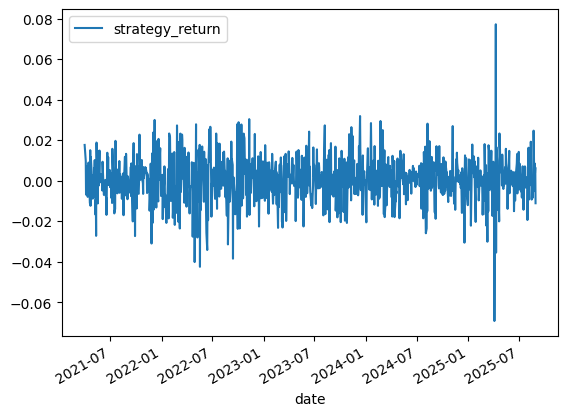

In [40]:
portfolio_df.plot()

In [41]:
spy = yf.download(tickers='SPY',
                  auto_adjust=False,
                    start='2022-02-01',
                    end='2025-10-31')

spy_ret = np.log(spy['Adj Close']).diff().dropna().rename({'SPY': 'SPY Buy and Hold'}, axis=1)


portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

[*********************100%***********************]  1 of 1 completed


In [42]:
portfolio_df

,strategy_return,SPY Buy and Hold
2022-02-02,0.008804,0.009667
2022-02-03,-0.009908,-0.023786
2022-02-04,0.008041,0.004691
2022-02-07,0.003418,-0.003214
2022-02-08,0.013529,0.008194
...,...,...
2025-08-25,-0.005030,-0.004411
2025-08-26,0.008604,0.004178
2025-08-27,0.003926,0.002276
2025-08-28,0.006651,0.003535


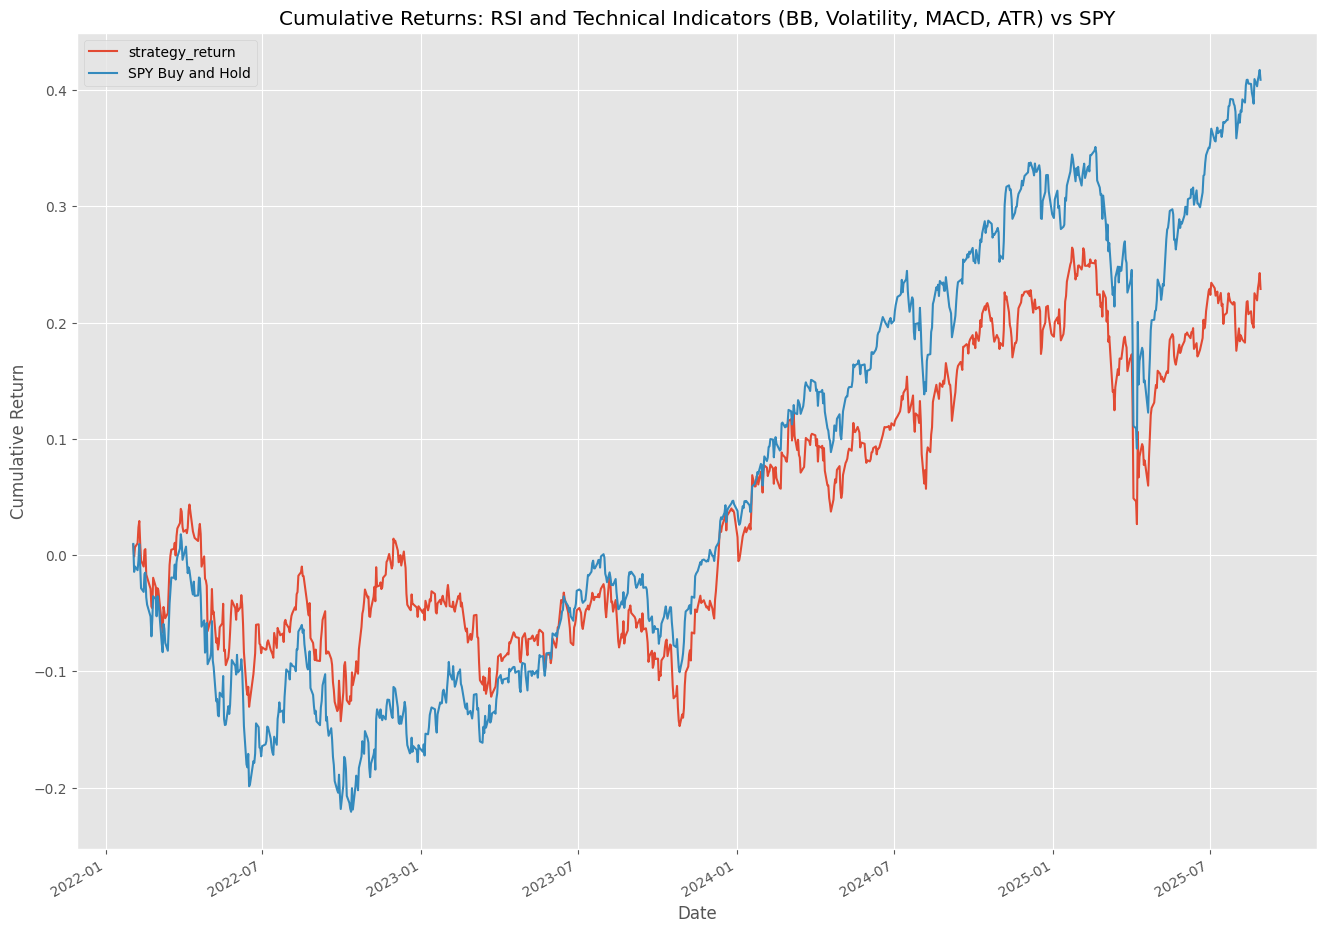

In [43]:
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16, 12))
portfolio_cumulative_return.plot(ax=ax)
plt.title("Cumulative Returns: RSI and Technical Indicators (BB, Volatility, MACD, ATR) vs SPY")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.show()